# P(s) curse: The decay of contact frenquency curse along genomic separation
a typical Hi-C map is dominated by a single pattern, the decay of contact frequency with genomic separation
In the Hi-C field, this decay is often referred to as 
* “expected” (because one “expects” a certain average contact frequency at a given genomic separation) or 
* “scaling” (which is borrowed from the polymer physics literature) or 
* **P(s) curve (contact probability, P, as a function of genomic separation, s).**


In [2]:
#@Author: Zhuowen Li
#@LastEdit: 2021/8/3 下午4:18:34
#@Version: 2
#@Description: explore .cool after cooler balance

In [3]:
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-poster')
import numpy as np
import pandas as pd
import bioframe
import cooler
import cooltools 
import cooltools.expected

In [4]:
clr = cooler.Cooler('/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/matrix/zb_DpnII_run04_TAIR10_unphased.matrix.mcool::/resolutions/1000')
#see cooler.Cooler basic info, following the guidance of https://cooler.readthedocs.io/en/latest/api.html#cooler.Cooler.matrix
hdf5_cool = clr.open()      
hdf5_cool['bins']['weight'][:]

array([0.0413062 , 0.03972102, 0.0815361 , ..., 0.02458299, 0.05587291,
              nan])

In [5]:
tair10_chr_file = "/public/home/lizw/data/IMPORTANT_genome/arabidopsis/tair10/all_chr.bed"
tair10_chr = pd.read_table(tair10_chr_file,header=None,names=['chrom','start','end'],converters={'chrom':str,'start':int,'end':int})

In [6]:
tair10_chr

,chrom,start,end
0,1,0,30427671
1,2,0,19698289
2,3,0,23459830
3,4,0,18585056
4,5,0,26975502


In [7]:
#tair10_centromere_location
tair10_cen_file = "/public/home/lizw/task/pore_c/sites/bed/tair9_cen_forIDE.bed"
tair10_cen = pd.read_table(tair10_cen_file,header=None,names=['chrom','start','end'],converters={'chrom':str,'start':int,'end':int})
tair10_start = tair10_cen.loc[:,('chrom','start')].rename(columns={'start':'cut'})
tair10_end = tair10_cen.loc[:,('chrom','end')].rename(columns={'end':'cut'})

#P(S) would be seperately calculate for individual chromosomal arms
tair10_cut = pd.concat([tair10_start,tair10_end],axis=0)

In [8]:
tair10_arms = bioframe.split(tair10_chr, points = tair10_cut ,cols_points=['chrom','cut'])

In [9]:
tair10_arms_retain = tair10_arms.drop(labels=[1,4,7,10,13])

In [10]:
#only contain the chromosome that contained in cool matrix
tair10_chr_in_cool = tair10_chr.set_index('chrom').loc[clr.chromnames].reset_index()
tair10_arms_retain = tair10_arms_retain.set_index("chrom").loc[clr.chromnames].reset_index()

In [11]:

tair10_arms_retain

,chrom,start,end
0,1,0,15086046
1,1,15087045,30427671
2,2,0,3607930
3,2,3608929,19698289
4,3,0,13799418
5,3,14209952,23459830
6,4,0,3956022
7,4,3957021,18585056
8,5,0,11725025
9,5,11726024,26975502


## Calculate the P(s) curve
To calculate the average contact frequency as a function of genomic separation, we will rely on the fact that **each diagonal of a Hi-C map contains interactions between loci separated by the same distance**. For example, the 3rd diagonal of our matrix contains interactions between loci separated by 3-4kb (note that diagonals are 0-indexed). Thus, we calculate the average P(s) at a given distance s as the average value of all pixels of the corresponding diagonal. This operation is performed by cooltools.expected.diagsum. Note that we calculate the P(s) separately for each chromosomal arm. This way we will ignore interactions accross the centromere, which is generally a good idea, since such interacts typically decay differently.

In [12]:
# cvd == contacts-vs-distance
# balanced 在.cool文件中，balance其实是给每个bin一个权重，所以矩阵每个值balance后是需要×对应的两个bin的weight的
cvd = cooltools.expected.diagsum(
    clr=clr,
    regions=tair10_arms_retain,
    transforms={'balanced':lambda p: p['count']*p['weight1']*p['weight2']}
)
# "Bad" pixels are inferred from the balancing weight column `weight_name` or provided directly in the form of an array `bad_bins`.

In [13]:
cvd #diag号在每个染色体内是一样顺序一样编号的→对应相同的cis-distance 是从中间往外数的。（因为arm是分开的，所以每个染色体会对应两套数据，其中0和1会被屏蔽（距离太近）

,region,diag,n_valid,count.sum,balanced.sum
0,1:0-15086046,0,14139,NaN,NaN
1,1:0-15086046,1,13804,NaN,NaN
2,1:0-15086046,2,13815,38506.0,60.685314
3,1:0-15086046,3,13777,29973.0,48.927479
4,1:0-15086046,4,13767,25332.0,41.684228
...,...,...,...,...,...
118735,5:11726024-26975502,15245,4,0.0,0.000000
118736,5:11726024-26975502,15246,3,1.0,0.000070
118737,5:11726024-26975502,15247,2,0.0,0.000000
118738,5:11726024-26975502,15248,1,0.0,0.000000


In [14]:
# Aggregate diagonals from different genomic regions together.
# Since all three calcuated statistics are additive, they can be aggregated
# easily via sum() functiond.
cvd_agg = (
    cvd
    .groupby('diag')
    .agg({'n_valid':'sum',
         'count.sum':'sum',
         'balanced.sum':'sum',
        }).reset_index()
)

In [15]:
cvd_agg

,diag,n_valid,count.sum,balanced.sum
0,0,114355,0.0,0.000000
1,1,111550,0.0,0.000000
2,2,111651,392585.0,506.077422
3,3,111463,290859.0,410.018514
4,4,111401,241020.0,349.312258
...,...,...,...,...
16086,16086,0,0.0,0.000000
16087,16087,1,0.0,0.000000
16088,16088,0,0.0,0.000000
16089,16089,0,0.0,0.000000


In [16]:
# Convert indices of diagonals into genomic separation, expressed in basepairs.
cvd_agg['s_bp'] = (
    cvd_agg['diag']
    * clr.binsize)

In [17]:
cvd_agg['count.avg'] = (
    cvd_agg['count.sum']
    / cvd_agg['n_valid']
)

cvd_agg['balanced.avg'] = (
    cvd_agg['balanced.sum']
    / cvd_agg['n_valid']
)

In [18]:
cvd_agg

,diag,n_valid,count.sum,balanced.sum,s_bp,count.avg,balanced.avg
0,0,114355,0.0,0.000000,0,0.000000,0.000000
1,1,111550,0.0,0.000000,1000,0.000000,0.000000
2,2,111651,392585.0,506.077422,2000,3.516180,0.004533
3,3,111463,290859.0,410.018514,3000,2.609467,0.003679
4,4,111401,241020.0,349.312258,4000,2.163535,0.003136
...,...,...,...,...,...,...,...
16086,16086,0,0.0,0.000000,16086000,NaN,NaN
16087,16087,1,0.0,0.000000,16087000,0.000000,0.000000
16088,16088,0,0.0,0.000000,16088000,NaN,NaN
16089,16089,0,0.0,0.000000,16089000,NaN,NaN


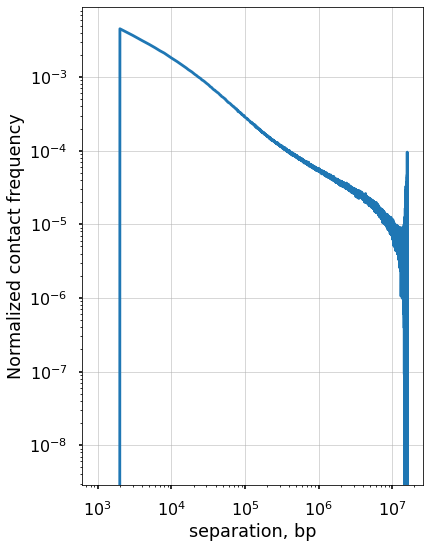

In [19]:
f, ax = plt.subplots(1,1)
ax.loglog(
    cvd_agg['s_bp'],
    cvd_agg['balanced.avg'],
)
ax.set(
    xlabel='separation, bp',
    ylabel='Normalized contact frequency')
ax.set_aspect(1.0)
ax.grid(lw=0.5)

[Text(0.5, 0, 'separation, bp'), Text(0, 0.5, 'Normalized contact frequency')]

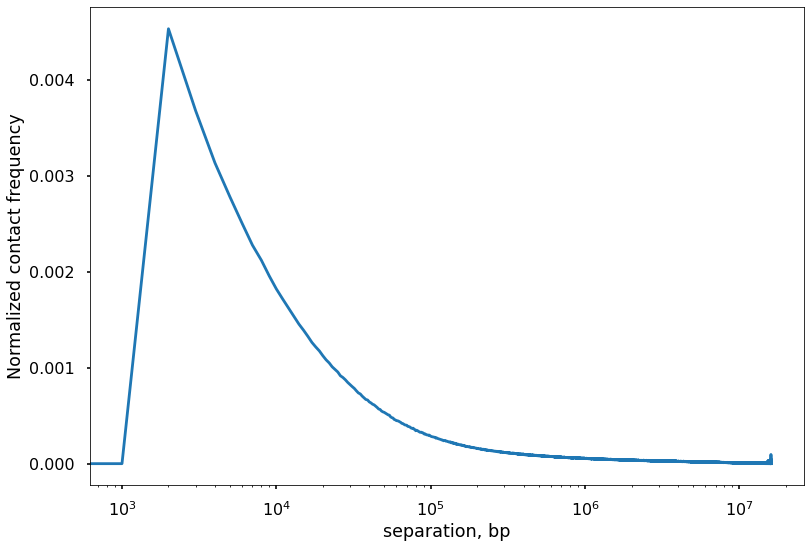

In [20]:
#oh!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#cite from 2009 Contact probability as a function of genomic distance averaged across thegenome(blue)shows a power law scaling
#嗯，呈现指数关系
f, ax = plt.subplots(1,1)
ax.plot(
    cvd_agg['s_bp'],
    cvd_agg['balanced.avg'],
)
ax.set_xscale('log')
ax.set(
    xlabel='separation, bp',
    ylabel='Normalized contact frequency')
#所以说frenquency 还真的不是概率而是就是那个值本身啊。。。
#normalized则是指矩阵normalization

# compare with raw
With this data, we also have an opportunity to test the effect of matrix balancing on the P(s) curve. Though, raw and balanced Hi-C data have different units, counts vs frequencies-that-sum-to-1.0. So, to plot the two on the same canvas, we have to normalize them to the same scale. Generally, there is no “best” way to normalize P(s) curves, different approaches rely on different assumptions, which are almost never true. The simplest assumption we can make is that our two P(s) curves must match at short distances.

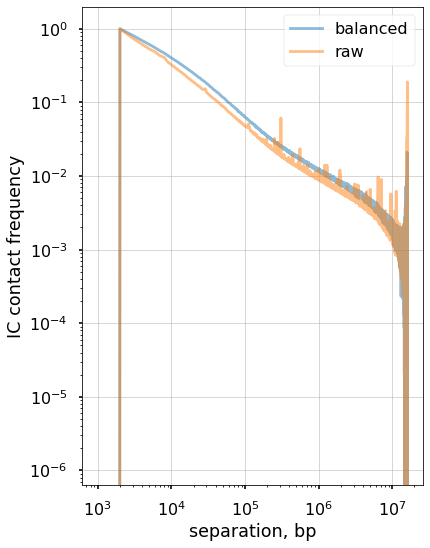

In [21]:
f, ax = plt.subplots(1,1)
# Below we normalize both P(s) curves by their first non-zero value(the max value)
# (remember that we mask the first 2 diagonals).
ax.loglog(
    cvd_agg['s_bp'],
    cvd_agg['balanced.avg'] / cvd_agg['balanced.avg'].iloc[2],
    alpha=0.5,
    label='balanced'
)
ax.loglog(
    cvd_agg['s_bp'],
    cvd_agg['count.avg'] / cvd_agg['count.avg'].iloc[2],
    alpha=0.5,
    label='raw'
)

ax.set(
    xlabel='separation, bp',
    ylabel='IC contact frequency')
ax.set_aspect(1.0)
ax.grid(lw=0.5)
_=ax.legend()

Smooth the P(s) curve with logarithmic binning.

# Logbin-expected aggregates P(s) curves per region over exponentially increasing distance bins.
幂律分布的参数估计(logarithmic bins) https://zhuanlan.zhihu.com/p/267563767

In [22]:
lb_cvd, lb_slopes, lb_distbins = cooltools.expected.logbin_expected(cvd)

# The resulting table contains P(s) curves for each individual region.
# Aggregating these curves into a single genome-wide curve is involving too,
# so we created a separate function for this too.
lb_cvd_agg, lb_slopes_agg = cooltools.expected.combine_binned_expected(
    lb_cvd,
    binned_exp_slope=lb_slopes
)

lb_cvd_agg['s_bp'] = lb_cvd_agg['diag.avg'] * clr.binsize
lb_slopes_agg['s_bp'] = lb_slopes_agg['diag.avg'] * clr.binsize

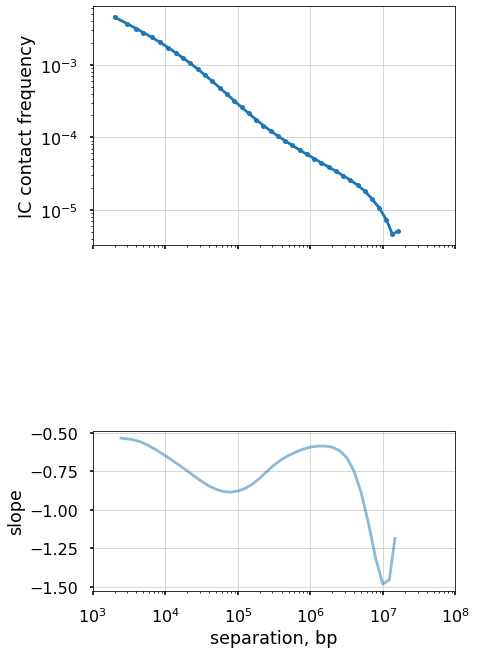

In [23]:
f, axs = plt.subplots(
    figsize=(6.5,13),
    nrows=2,
    gridspec_kw={'height_ratios':[6,2]},
    sharex=True)
ax = axs[0]
ax.loglog(
    lb_cvd_agg['s_bp'],
    lb_cvd_agg['balanced.avg'],
    'o-',
    markersize=5,
)

ax.set(
    ylabel='IC contact frequency',
    xlim=(1e3,1e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)


ax = axs[1]
ax.semilogx(
    lb_slopes_agg['s_bp'],
    lb_slopes_agg['slope'],
    alpha=0.5
)

ax.set(
    xlabel='separation, bp',
    ylabel='slope')

ax.grid(lw=0.5)

[Text(0.5, 0, 'Separation(bp)'), Text(0, 0.5, 'Normalized contact frequency')]

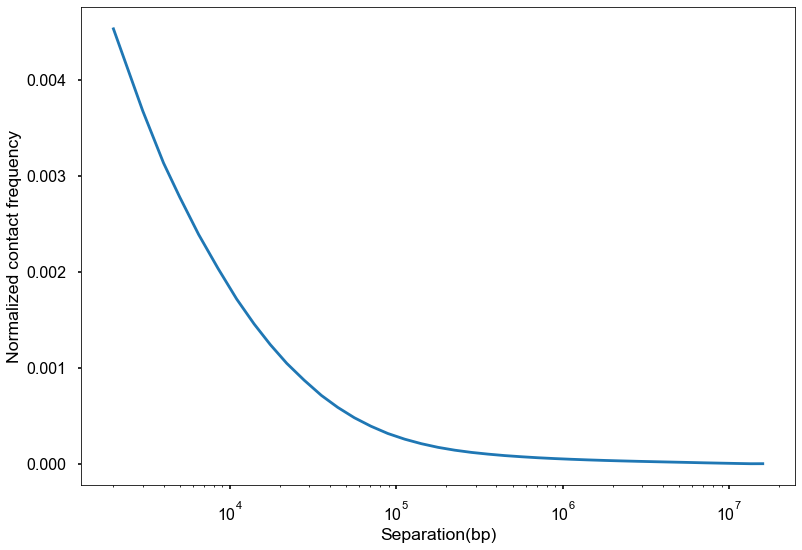

In [24]:
#font setting
import matplotlib.font_manager as font_manager
font_dirs = ["/public/home/lizw/software/font"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 20
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
f, ax = plt.subplots(1,1)
ax.plot(
    lb_cvd_agg['s_bp'],
    lb_cvd_agg['balanced.avg'],
)
ax.set_xscale('log')
ax.set(
    xlabel='Separation(bp)',
    ylabel='Normalized contact frequency')
#所以说frenquency 还真的不是概率而是就是那个值本身啊。。。
#normalized则是指矩阵normalization

## 除最大值（porec和SPRITE图的效果，确实比其他图更好看）

In [28]:
lb_cvd_agg['nor_balanced.avg'] = lb_cvd_agg['balanced.avg']/lb_cvd_agg['balanced.avg'].max()

[Text(0.5, 0, 'Separation(bp)'), Text(0, 0.5, 'Normalized contact frequency')]

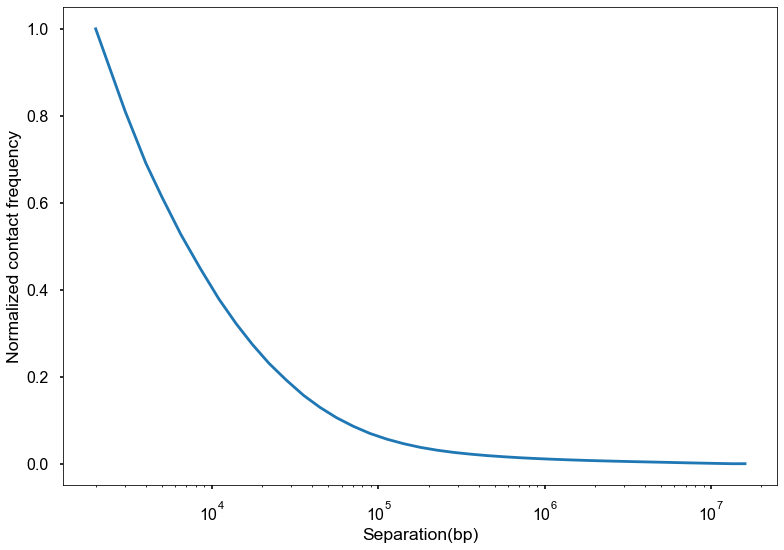

In [29]:
#font setting
import matplotlib.font_manager as font_manager
font_dirs = ["/public/home/lizw/software/font"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 20
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
f, ax = plt.subplots(1,1)
ax.plot(
    lb_cvd_agg['s_bp'],
    lb_cvd_agg['nor_balanced.avg'], #使用除以最大值后的列
)
ax.set_xscale('log')
ax.set(
    xlabel='Separation(bp)',
    ylabel='Normalized contact frequency')
#所以说frenquency 还真的不是概率而是就是那个值本身啊。。。
#normalized则是指矩阵normalization